## Detecting Pneumonia from Chest X-Rays

This dataset contains roughly 6000 images of chest X-rays, for patients that either have pneumonia, or are healthy. Pneumonia is an inflamation of the lungs. I shall be trying to build a model that can predict whether a patient has pneumonia from their chest x-ray image. There are only two classes we're focused on for this dataset: Patient has pneumonia or Patient is healthy. For this binary classification task, I shall be using PyTorch to build a CNN model, as well as for data augmentation.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn

Checks whether GPU support is available and can be used for training the model.

In [3]:
print(torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

True


In [4]:
import os
import cv2
from PIL import Image
from datetime import datetime

label_to_type = {0: "NORMAL", 1: "PNEUMONIA"}
type_to_label = {"NORMAL": 0, "PNEUMONIA": 1}

train_dir = "train/"
    
x_train = []
y_train = []

for cell_type in os.listdir(train_dir):
    print("{0}: Loading {1} training images...".format(datetime.now().time(), cell_type))
    for img in os.listdir(train_dir + cell_type):
        y_train.append(type_to_label[cell_type])
        img = Image.open(train_dir + cell_type + "/" + img)
        img = img.convert(mode="L")
        img = img.resize((150, 150))
        x_train.append(img)
        
y_train = np.array(y_train)
y_train = torch.from_numpy(y_train).to(device)

13:48:25.327229: Loading NORMAL training images...
13:49:39.666065: Loading PNEUMONIA training images...


In [5]:
len(x_train)

5216

So the training set has 5216 images in it. The images have all been grayscaled and resized to 150x150.

The training set has not converted the images to tensors, as torchvision's transformation methods only work on PIL images. After the images have been augmented, they will be converted to tensors.

In [6]:
test_dir = "test/"
    
x_test = []
y_test = []

for cell_type in os.listdir(test_dir):
    print("{0}: Loading {1} test images...".format(datetime.now().time(), cell_type))
    for img in os.listdir(test_dir + cell_type):
        y_test.append(type_to_label[cell_type])
        img = Image.open(test_dir + cell_type + "/" + img)
        img = img.convert(mode="L")
        img = img.resize((150, 150))
        x_test.append(img.getdata())
        
x_test = np.array(x_test)
x_test = x_test.reshape(-1, 1, 150, 150)
x_test = torch.from_numpy(x_test).float().to(device) / 255
y_test = np.array(y_test)
y_test = torch.from_numpy(y_test).float().to(device)

13:50:56.006012: Loading NORMAL test images...
13:51:05.477984: Loading PNEUMONIA test images...


In [7]:
x_test.shape

torch.Size([624, 1, 150, 150])

The test set has 624 images in it. The test images are already converted to tensors as we will not be performing data augmentation on them.

# Dataset Visualisation

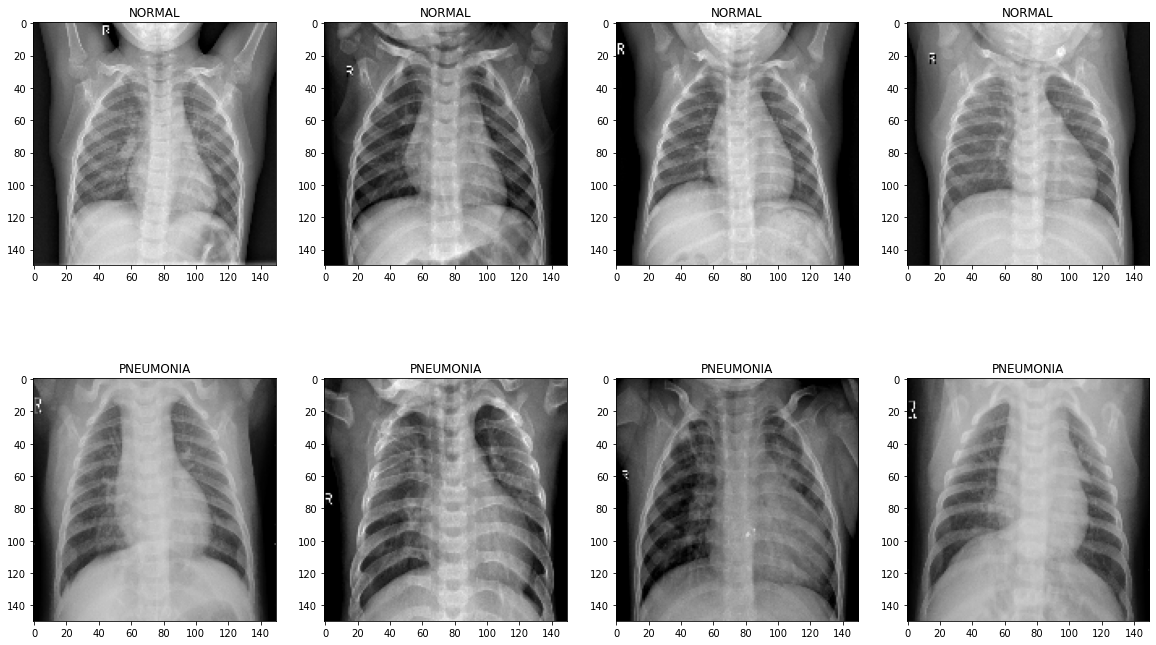

In [8]:
train_dir = "train/"
sample_images = ["NORMAL/IM-0115-0001.jpeg", "NORMAL/IM-0117-0001.jpeg", "NORMAL/IM-0119-0001.jpeg","NORMAL/IM-0122-0001.jpeg",
                 "PNEUMONIA/person1000_virus_1681.jpeg", "PNEUMONIA/person1001_bacteria_2932.jpeg", 
                 "PNEUMONIA/person1002_bacteria_2933.jpeg", "PNEUMONIA/person1007_virus_1690.jpeg"]
labels = ["NORMAL", "PNEUMONIA"]

fig, ax = plt.subplots(2,4, figsize=(20,12))

n = 0
for i in range(2):
    for j in range(4):
        img = cv2.imread(train_dir + sample_images[n], 0) 
        img = cv2.resize(img, (150, 150))
        ax[i,j].imshow(img, cmap='gray')
        ax[i,j].set_title(labels[i])
        n += 1

Looking at these sample images, it's quite difficult to tell the difference between a patient with pneumonia, and one that is healthy. Pneumonia is inflammation of the lungs, caused by bacterial/viral infection. Either a single lung or both lungs can be affected, and they fill with pus and solidify. 

Without further medical knowledge, it's still quite difficult to see an obvious difference between the two rows of X-rays. Hopefully my visualisation model will be able to recognise a pattern between the two cases far better than I can with the human eye. 

Text(0.5, 1.0, 'Test Set')

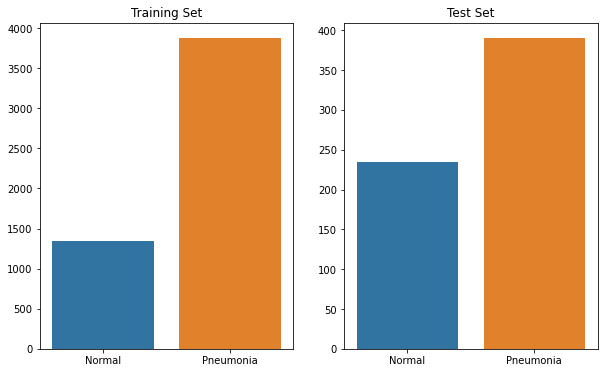

In [9]:
train_normal_count = (y_train == 0).sum().item()
train_pneumonia_count = (y_train == 1).sum().item()

test_normal_count = (y_test == 0).sum().item()
test_pneumonia_count = (y_test == 1).sum().item()

fig, ax = plt.subplots(1, 2, figsize=(10,6))
sns.barplot(x=["Normal", "Pneumonia"], y=[train_normal_count, train_pneumonia_count], ax=ax[0])
sns.barplot(x=["Normal", "Pneumonia"], y=[test_normal_count, test_pneumonia_count], ax=ax[1])
ax[0].set_title("Training Set")
ax[1].set_title("Test Set")

Here we can see there is a serious imbalance between the images provided for both classes. There are far more images of pneumonia, particularly in the training set. In order to prevent the model from overfitting towards pneumonia, I will have to use data augmentation on the provided images. This way, I will have a much larger and more equal number of images for both classes. 

# Visualisation Model

In [10]:
class Net(nn.Module):
    
    def __init__(self, input_shape):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256)
        )
        
        cnn_out = self.cnn_layers(torch.zeros(1, *input_shape))
        flat_shape = int(np.prod(cnn_out.size()))
        
        self.linear_layers = nn.Sequential(
            nn.Linear(flat_shape, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [11]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms

class Dataset(Dataset):
    def __init__(self, X, y):
        self.images = X
        self.labels = y
        self.transform = transforms.Compose([transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(1.0, 1.5), shear=10)
                                            ,transforms.ToTensor()])
        
    def __getitem__(self, index):
        image = self.transform(self.images[index]).to(device)
        image = image / 255
        label = self.labels[index]
        return (image, label)

    def __len__(self):
        return len(self.images)

The Dataset class above is used so that transformations can be applied to the training images for data augmentation.

In [12]:
from torch.utils.data import DataLoader 

BATCH_SIZE = 32
train_dataset = Dataset(x_train, y_train)
data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
model = Net([1, 150, 150]).to(device)
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
best_val_acc = 0

for epoch in range(200):
    loss_avg = 0
    accuracy_avg = 0
    steps = 0
    for batch_idx, (images, labels) in enumerate(data_loader):

        y_pred = model(images)
        
        loss = criterion(y_pred, labels)
        loss_avg += loss.item()
        steps += 1
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
        correct = (y_pred.argmax(1).detach() == labels).float().sum()
        accuracy = (correct.item() / BATCH_SIZE) * 100
        accuracy_avg += accuracy
    
    if device == "cuda":
        torch.cuda.empty_cache() # free up GPU memory space
    
    y_pred = model(x_test).argmax(1).detach()
    correct = (y_pred == y_test).float().sum()
    val_accuracy = (correct.item() / len(y_test)) * 100
    
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), "/kaggle/working/model_weights.pt")
    
    loss_avg = loss_avg / steps
    accuracy_avg = accuracy_avg / steps
    
    print("Epoch: {0}, loss: {1:.6f}, acc: {2:.2f}%, val acc: {3:.2f}%".format(epoch, loss_avg, accuracy_avg, val_accuracy))


Epoch: 0, loss: 0.427436, acc: 88.17%, val acc: 83.49%
Epoch: 1, loss: 0.424611, acc: 88.65%, val acc: 80.93%
Epoch: 2, loss: 0.408382, acc: 90.34%, val acc: 76.44%
Epoch: 3, loss: 0.407480, acc: 90.45%, val acc: 85.10%
Epoch: 4, loss: 0.418968, acc: 89.30%, val acc: 84.13%
Epoch: 5, loss: 0.407444, acc: 90.53%, val acc: 84.94%
Epoch: 6, loss: 0.427360, acc: 88.46%, val acc: 85.74%
Epoch: 7, loss: 0.408635, acc: 90.38%, val acc: 76.44%
Epoch: 8, loss: 0.405222, acc: 90.78%, val acc: 83.33%
Epoch: 9, loss: 0.408073, acc: 90.47%, val acc: 80.93%
Epoch: 10, loss: 0.396016, acc: 91.72%, val acc: 72.44%
Epoch: 11, loss: 0.433453, acc: 87.94%, val acc: 85.26%
Epoch: 12, loss: 0.408176, acc: 90.49%, val acc: 75.64%
Epoch: 13, loss: 0.411469, acc: 90.13%, val acc: 76.60%
Epoch: 14, loss: 0.411035, acc: 90.22%, val acc: 79.17%
Epoch: 15, loss: 0.406423, acc: 90.66%, val acc: 84.29%
Epoch: 16, loss: 0.396881, acc: 91.62%, val acc: 79.65%
Epoch: 17, loss: 0.398202, acc: 91.49%, val acc: 84.94%
Ep

Epoch: 146, loss: 0.389035, acc: 92.43%, val acc: 81.89%
Epoch: 147, loss: 0.397306, acc: 91.58%, val acc: 84.78%
Epoch: 148, loss: 0.402426, acc: 91.09%, val acc: 80.29%
Epoch: 149, loss: 0.393612, acc: 91.97%, val acc: 83.97%
Epoch: 150, loss: 0.413374, acc: 89.99%, val acc: 85.74%
Epoch: 151, loss: 0.402659, acc: 91.05%, val acc: 83.17%
Epoch: 152, loss: 0.405374, acc: 90.78%, val acc: 83.97%
Epoch: 153, loss: 0.412685, acc: 90.05%, val acc: 83.17%
Epoch: 154, loss: 0.406260, acc: 90.70%, val acc: 82.37%
Epoch: 155, loss: 0.386692, acc: 92.66%, val acc: 82.21%
Epoch: 156, loss: 0.387015, acc: 92.62%, val acc: 84.94%
Epoch: 157, loss: 0.387344, acc: 92.58%, val acc: 83.81%
Epoch: 158, loss: 0.378894, acc: 93.42%, val acc: 82.05%
Epoch: 159, loss: 0.378391, acc: 93.48%, val acc: 82.37%
Epoch: 160, loss: 0.382864, acc: 93.04%, val acc: 80.77%
Epoch: 161, loss: 0.389227, acc: 92.39%, val acc: 84.78%
Epoch: 162, loss: 0.380967, acc: 93.23%, val acc: 83.01%
Epoch: 163, loss: 0.385332, acc

In [15]:
print("Best validation accuracy: {0:.2f}%".format(best_val_acc))

Best validation accuracy: 86.86%


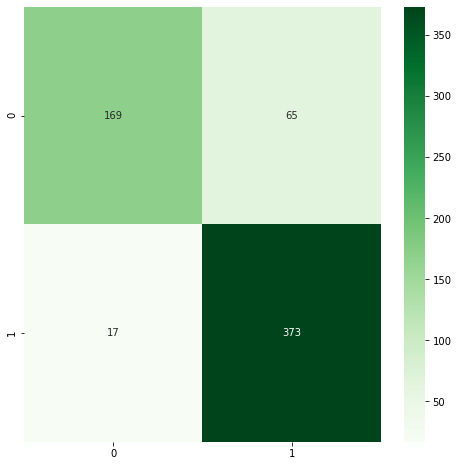

In [16]:
from sklearn.metrics import confusion_matrix

model.load_state_dict(torch.load("model_weights.pt"))
y_pred = model(x_test).argmax(1).detach()

cm = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().numpy(), labels=[0,1])
cm = pd.DataFrame(cm, index=[0,1], columns=[0,1])

plt.figure(figsize=(8,8))
sns.heatmap(cm, cmap= "Greens", annot=True, fmt='')

Accuracy per class:

Normal (0) = 169/234 = 72.2% 

Pneumonia (1) = 373/390 = 95.6%

# Conclusion

The best test accuracy achieved by the model during training was just under 87%. This is a fairly good accuracy, but it's not reliable enough to be deployed on it's own for diagnosis. The best model is predicting Pneumonia correctly 95.6% of the time, but Normal only 72.2% of the time. There is still a problem with the model overfitting more towards pneumonia, and not for normal healthy patients. There is also a general case of overfitting since the training accuracy is generally quite a bit higher than the test accuracy, throughout the 200 epochs.

To improve on this, I could reduce the number of layers in the model, and try experimenting with differing kinds of data augmentation. I could also try different batch sizes, as well as adjusting the learning rate for the Adam optimiser. 